Tom Barclay's xoflares on EPIC-246301900

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
import theano
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt
from scipy.signal import savgol_filter
from pymc3.step_methods.hmc import quadpotential
import corner


In [2]:
print(xo.__version__)
print(theano.__version__)
print(pm.__version__)
print(lk.__version__)

0.2.0
1.0.4
3.7
1.0.1


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/lightkurve-1.0.1-py3.7.egg/lightkurve/search.py:181: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning)


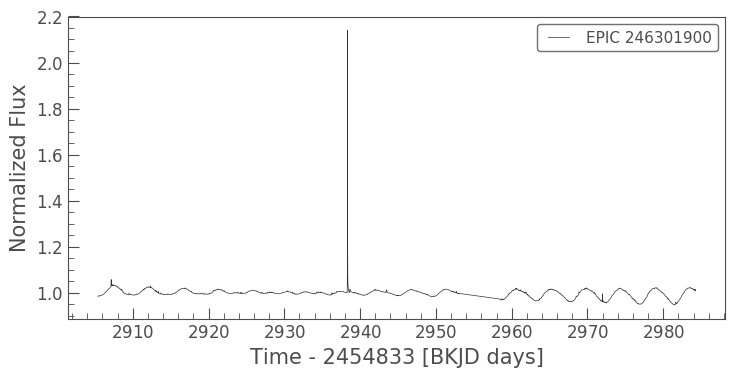

In [3]:
lc = lk.search_targetpixelfile('EPIC 246301900').download()
lc.to_lightcurve().plot()
ref_time = 0.5 * (lc.time.min() + lc.time.max())

In [4]:
lc = lc.to_lightcurve()
print(lc.flux.shape)

(3379,)


**Post Superflare**

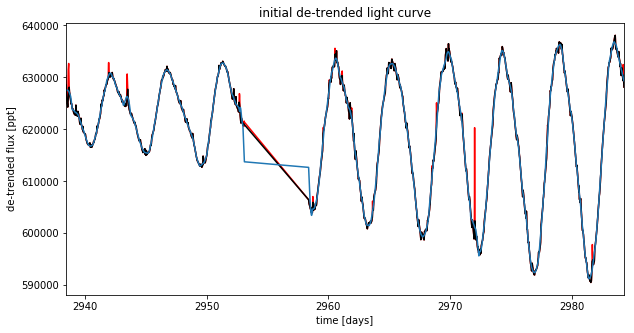

In [8]:
post_flux = lc.flux[1529:]
post_time = lc.time[1529:]
# get a smoothed version of the pre-flare light curve
smooth = savgol_filter(post_flux, 31, polyorder=3)
resid = post_flux - smooth
mask = resid < 2*np.sqrt(np.mean(resid**2))

plt.figure(figsize=(10, 5))
plt.plot(post_time, post_flux, "r")
plt.plot(post_time[mask], post_flux[mask], "k")
plt.plot(post_time, smooth)
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("initial de-trended light curve")
plt.xlim(post_time.min(), post_time.max());

In [9]:
# find some flares
post_cadenceno = lc.cadenceno[1529:]
mflare = resid < 3.5 * np.sqrt(np.mean(resid**2))
cads = post_cadenceno - post_cadenceno[0]
ref_time_post = 0.5 * (post_time.min() + post_time.max())
x = post_time - ref_time_post
y = resid #  we're working with the data with a savgol subtracted

fidx = cads[~mflare][:-1]#[np.diff(cads[~mflare]) < 1]
npts = np.array([])
i = 0
n = 1
while True:
    try:
        if fidx[i + 1] == fidx[i] + n:
            fidx = np.delete(fidx, i + 1)
            n += 1
        else:
            npts = np.r_[npts, n+1]
            i += 1
            n = 1
    except IndexError:
        npts = np.r_[npts, n+1]
        break
tpeaks = np.array([x[(post_cadenceno - post_cadenceno[0]) == fidx[i]] for i in range(len(fidx))]).T[0]
ampls = np.array([resid[(post_cadenceno - post_cadenceno[0]) == fidx[i]] for i in range(len(fidx))]).T[0]
fwhms = np.asarray(npts) * (2/1440)
npeaks = np.shape(tpeaks)[0]
print(npeaks)

7


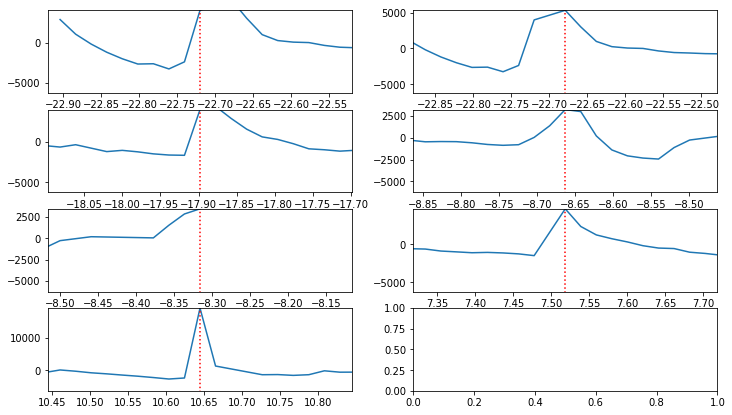

In [10]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
axes = axes.flatten()
for i in range(npeaks):
    ax = axes[i]
    ax.plot(x, y)
    ax.axvline(tpeaks[i], np.min(y), np.max(y), color='r', linestyle=':')
    ax.set_xlim(tpeaks[i]-0.2, tpeaks[i]+0.2)
    ax.set_ylim(np.min(y), np.max(ampls[i]+3))

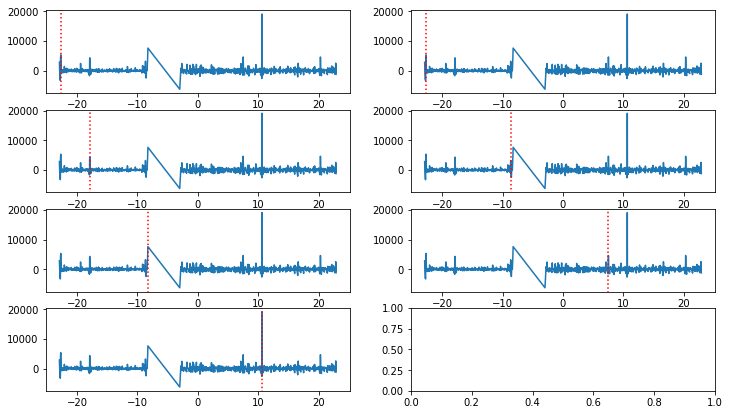

In [11]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
axes = axes.flatten()
for i in range(npeaks):
    ax = axes[i]
    ax.plot(x, y)
    ax.axvline(tpeaks[i], np.min(y), np.max(y), color='r', linestyle=':')
    #ax.set_xlim(tpeaks[i]-0.2, tpeaks[i]+0.2)
    #ax.set_ylim(np.min(y), np.max(ampls[i]+3))

In [12]:
# this is the flare model implemented in theano
def get_light_curve(time, tpeaks, fwhms, ampls, texp=None, oversample=7):
    time = time.astype('float64')
    time = tt.as_tensor_variable(time)
    
    if texp is None:
        tgrid = time
    if texp is not None:
        # taking this oversample code from
        # https://github.com/dfm/exoplanet
        # and https://github.com/lkreidberg/batman
        oversample = int(oversample)
        oversample += 1 - oversample % 2
        dt = np.linspace(-texp / 2., texp / 2.,
                         oversample)
        tgrid = tt.shape_padright(time) + dt
        
    multiflare_lc = multiflaremodel(tgrid, tpeaks, fwhms, ampls)
    
    if texp is not None:
        multiflare_lc = tt.mean(tt.reshape(multiflare_lc, (-1, oversample)),
            axis=1)

    return multiflare_lc

def multiflaremodel(t, tpeaks, fwhms, ampls):
    t = t.astype('float64')
    t = tt.as_tensor_variable(t)
    multiflare_lc = tt.zeros_like(t)
    flare_lc = tt.zeros_like(t)
    
    def scan_func(tpeak, fwhm, ampl):
        zeropad_flare_lc = tt.zeros_like(t)
        tcut = (((t - tpeak)/fwhm > -1.) * ((t - tpeak)/fwhm < 20.)).nonzero()
        flare_lc = _flaremodel(t[tcut], tpeak, fwhm, ampl)
        zeropad_flare_lc = tt.set_subtensor(zeropad_flare_lc[tcut],  flare_lc)
        return zeropad_flare_lc
    
    components, updates = theano.scan(fn=scan_func,
                                      sequences=[tpeaks, fwhms, ampls],
                                      )
    multiflare_lc = tt.sum(components, axis=0)
    
#     for i in range(npeaks):
#         tcut = (((t - tpeaks[i])/fwhms[i] > -1.) * ((t - tpeaks[i])/fwhms[i] < 20.)).nonzero()
#         flare_lc = _flaremodel(t[tcut], tpeaks[i], fwhms[i], ampls[i])
#         multiflare_lc = tt.set_subtensor(multiflare_lc[tcut],  multiflare_lc[tcut] + flare_lc)
    return multiflare_lc

def _flaremodel(t, tpeak, fwhm, ampl):
    # reuses some code from AltaiPony and Apaloosa
    t = tt.as_tensor_variable(t)
    flare_lc = tt.zeros_like(t)
    flare_lc = tt.where((t <= tpeak) * ((t - tpeak)/fwhm > -1.),
                        before_flare(t, tpeak, fwhm, ampl),
                        flare_lc
                       )
    flare_lc = tt.where((t > tpeak) * ((t - tpeak)/fwhm < 20.),
                        after_flare(t, tpeak, fwhm, ampl),
                        flare_lc
                       )
    return flare_lc

def before_flare(t, tpeak, fwhm, ampl):
    _fr = [1.00000, 1.94053, -0.175084, -2.24588, -1.12498]
    fout = ((_fr[0] + _fr[1] * ((t - tpeak) / fwhm) +
                        _fr[2] * ((t - tpeak) / fwhm)**2. +
                        _fr[3] * ((t - tpeak) / fwhm)**3. +
                        _fr[4] * ((t - tpeak) / fwhm)**4. ) *
                        ampl)
    return fout

def after_flare(t, tpeak, fwhm, ampl):
    _fd = [0.689008, -1.60053, 0.302963, -0.278318]
    fout = ((_fd[0] * tt.exp( ((t - tpeak) / fwhm) * _fd[1]) +
             _fd[2] * tt.exp( ((t - tpeak) / fwhm) * _fd[3] )) *
            ampl)
    return fout

xx = tt.dvector('xx')
tpeaksx = tt.dvector('tpeaksx')
fwhmsx = tt.dvector('fwhmsx')
amplsx = tt.dvector('amplsx')
multiflare = theano.function([xx, tpeaksx, fwhmsx, amplsx],
                    get_light_curve(xx, tpeaksx, fwhmsx, amplsx))



In [13]:
with pm.Model() as model:
    npeaks = np.shape(tpeaks)[0]
    mean = pm.Normal("mean", mu=0, sd=3.0, testval=0)
    logs2 = pm.Normal("logs2", mu=np.log(np.var(y)), sd=2.0)
    tpeak = pm.Normal("tpeak", mu=tpeaks, sd=np.ones_like(tpeaks) * 0.003,
                      testval=tpeaks, shape=npeaks)
    logFwhm = pm.Normal("logFwhm", mu=np.log(fwhms), sd=1.0, testval=np.log(fwhms),
                        shape=npeaks)
    logAmpl = pm.Normal("logAmpl", mu=np.log(ampls), sd=1.0, testval=np.log(ampls),
                        shape=npeaks)
    
    fwhm = pm.Deterministic("fwhm", tt.exp(logFwhm))
    ampl = pm.Deterministic("ampl", tt.exp(logAmpl))
    
    #flare_lc = get_light_curve(x, tpeak, fwhm, ampl, texp=texp, oversample=15)
    flare_lc = get_light_curve(x, tpeak, fwhm, ampl, oversample=15)
    pm.Deterministic("flare_lc", flare_lc)
    pm.Normal("obs", mu=flare_lc + mean, sd=tt.exp(2*logs2), observed=y)
    
    map_soln = xo.optimize(start=model.test_point, vars=[fwhm, mean])
    map_soln = xo.optimize(start=map_soln, vars=[ampl, mean])
    map_soln = xo.optimize(start=map_soln, vars=[fwhm, ampl])
    map_soln = xo.optimize(start=map_soln, vars=[tpeak])
    
    approx = pm.MeanField(start=map_soln)
    pm.fit(method=pm.KLqp(approx), n=200000,
            obj_optimizer=pm.adagrad_window
        )
    start = approx.sample(draws=4, )
    start = list(start)
    stds = approx.bij.rmap(approx.std.eval())
    cov = model.dict_to_array(stds) ** 2
    potential = quadpotential.QuadPotentialDiag(cov)

optimizing logp for variables: ['mean', 'logFwhm']
message: Optimization terminated successfully.
logp: -51840.49379169106 -> -51840.49379169106
optimizing logp for variables: ['mean', 'logAmpl']
message: Optimization terminated successfully.
logp: -51840.49379169106 -> -51840.49379169106
optimizing logp for variables: ['logAmpl', 'logFwhm']
message: Optimization terminated successfully.
logp: -51840.49379169106 -> -51840.49379169106
optimizing logp for variables: ['tpeak']
message: Optimization terminated successfully.
logp: -51840.49379169106 -> -51840.49379169106


Average Loss = 14,705: 100%|██████████| 200000/200000 [08:17<00:00, 402.03it/s]  
Finished [100%]: Average Loss = 14,705


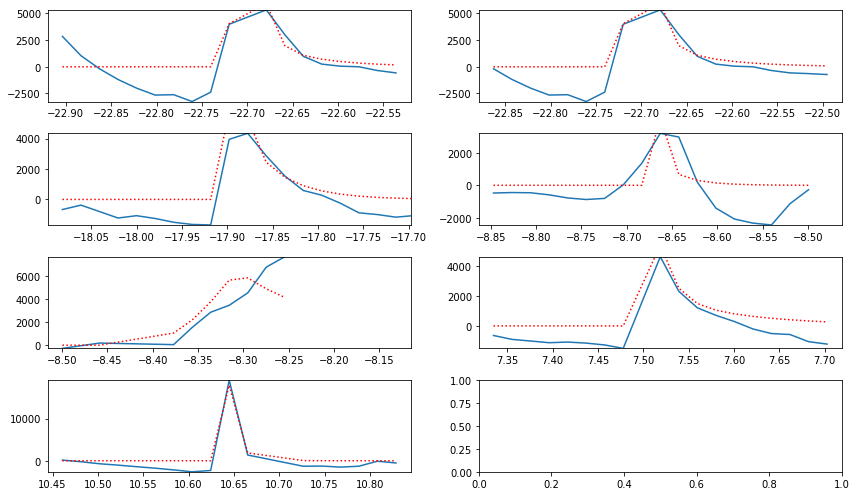

In [14]:
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks])
axes = axes.flatten()
tps = start[0]['tpeak']
for i in range(npeaks):
    timemask = (x >= tps[i]-0.2) * (x < tps[i]+0.2) # true for values within +/- 0.2 of peak indices
    ax = axes[i]
    ax.plot(x[timemask], y[timemask])
    ax.plot(x[timemask], start[0]['flare_lc'][timemask], ':r')
    ax.set_xlim(tpeaks[i]-0.2, tpeaks[i]+0.2)
    ax.set_ylim(np.min(y[timemask]), np.max(y[timemask]))
fig.tight_layout()

In [15]:
with model:
    step = pm.NUTS(potential=potential, target_accept=0.9)
    trace = pm.sample(draws=2400, tune=200, step=step, start=start, cores=4)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logAmpl, logFwhm, tpeak, logs2, mean]
Sampling 4 chains:  69%|██████▊   | 7142/10400 [20:27<09:20,  5.82draws/s]  
The estimated number of effective samples is smaller than 200 for some parameters.


In [16]:
pm.summary(trace, varnames= ['logAmpl', 'logFwhm', 'tpeak', 'logs2', 'mean'], )

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
logAmpl__0,8.827357,0.541464,0.013393,7.996901,9.999142,1450.702484,1.001675
logAmpl__1,9.316717,0.580005,0.018958,8.404437,10.475094,903.859091,1.004866
logAmpl__2,9.809532,0.326186,0.007986,9.142775,10.404033,1619.413111,1.001631
logAmpl__3,9.519826,0.791347,0.029557,8.090753,10.919779,569.213962,1.006889
logAmpl__4,8.785454,0.076982,0.000994,8.634115,8.933100,6383.054639,1.000073
logAmpl__5,9.069572,0.452510,0.012971,8.299233,9.949642,1165.366277,1.001449
logAmpl__6,10.394706,0.428483,0.021319,9.819251,11.231519,330.849969,1.020429
logFwhm__0,-5.335560,0.826926,0.014234,-6.945614,-3.917743,2933.659611,1.000017
logFwhm__1,-4.845207,0.477474,0.011639,-5.730941,-3.956552,1625.000204,1.005495
logFwhm__2,-4.645268,0.266333,0.006458,-5.163198,-4.119418,1659.361120,1.001575


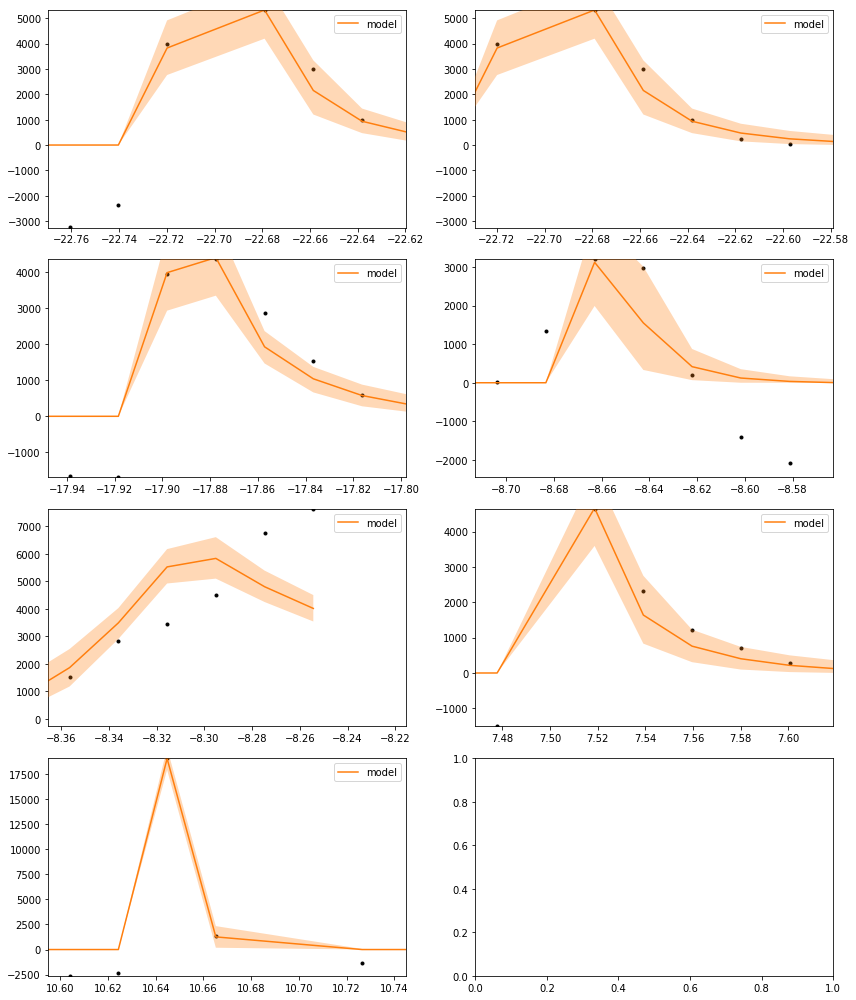

In [17]:
flc =  np.percentile(trace['flare_lc'], [5, 50, 95], axis=0)
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks*2])
axes = axes.flatten()
for i in range(npeaks):
    timemask = (x >= tpeaks[i]-0.2) * (x < tpeaks[i]+0.2)
    ax = axes[i]
    ax.plot(x[timemask], y[timemask], '.k')
    ax.plot(x[timemask], flc[1][timemask], color="C1", label="model")
    art = ax.fill_between(x[timemask], flc[0][timemask],
                          flc[2][timemask], color="C1", alpha=0.3,
                               zorder=1000)
    art.set_edgecolor("none")
    ax.set_xlim(tpeaks[i]-0.05, tpeaks[i]+0.1)
    ax.set_ylim(np.min(y[timemask]) - 1, 1 + np.max(y[timemask]))
    ax.legend()
    
fig.tight_layout()

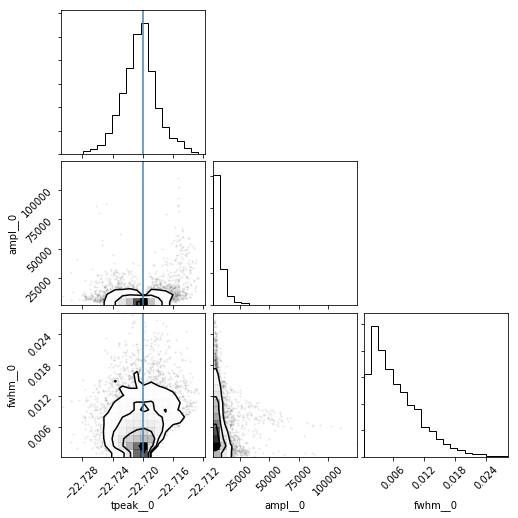

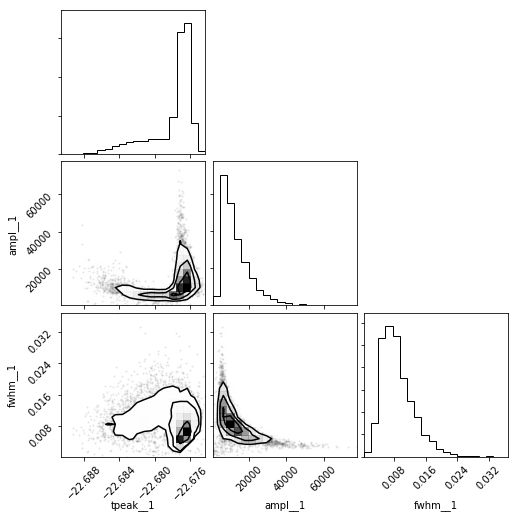

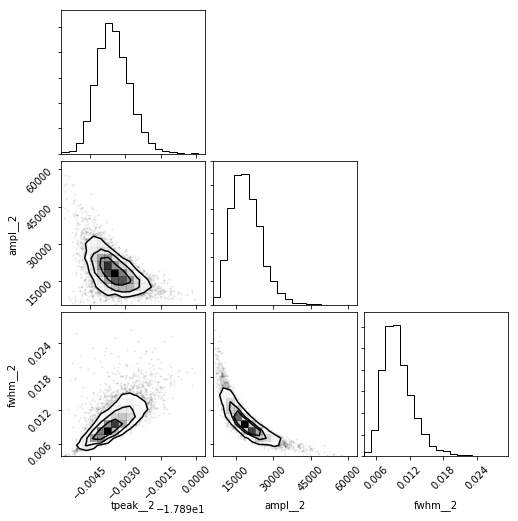

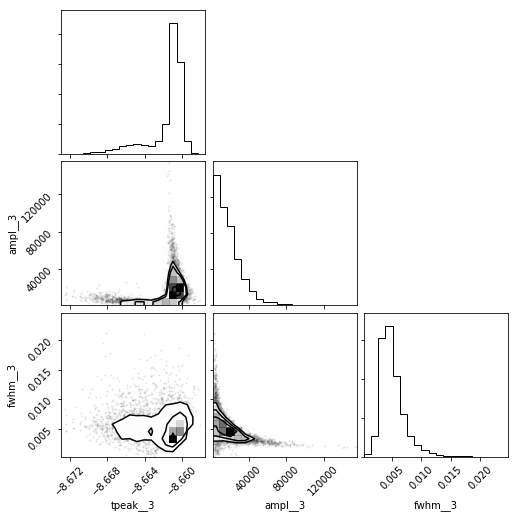

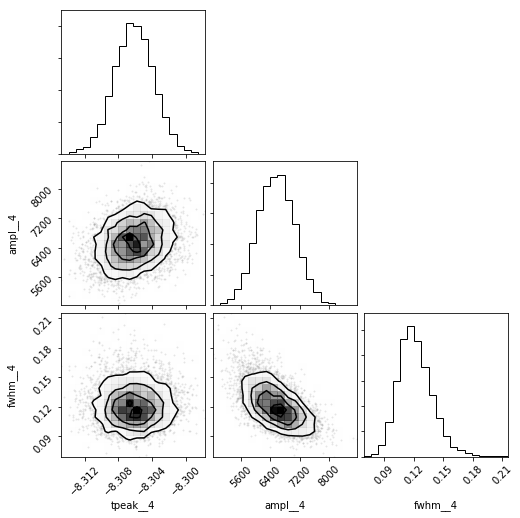

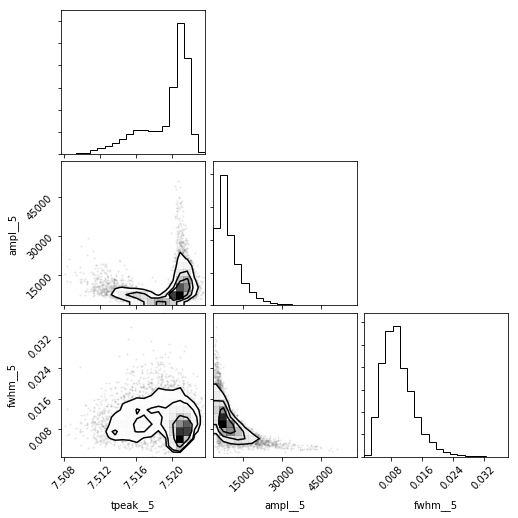

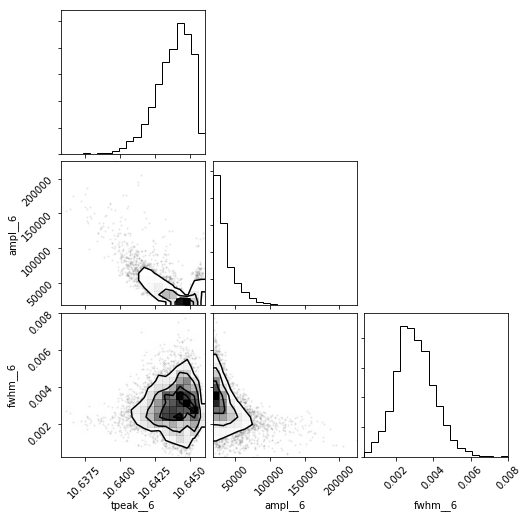

In [18]:
# corners
samples = pm.trace_to_dataframe(trace, varnames=['tpeak', 'ampl', 'fwhm'])
for i in range(trace['tpeak'].shape[1]):
    corner.corner(samples.loc[:,
                              ['tpeak__{}'.format(i), 'ampl__{}'.format(i),
                               'fwhm__{}'.format(i)]], truths=tpeaks);

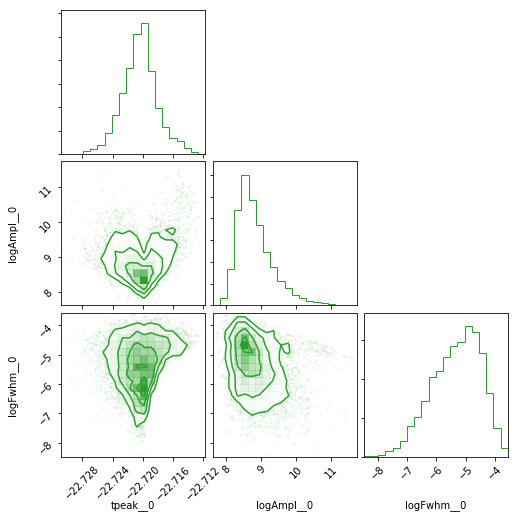

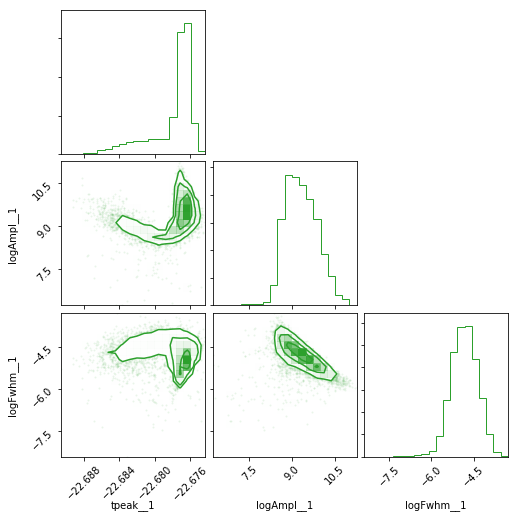

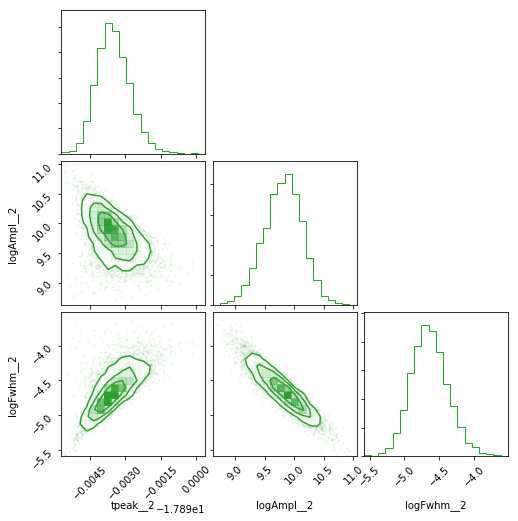

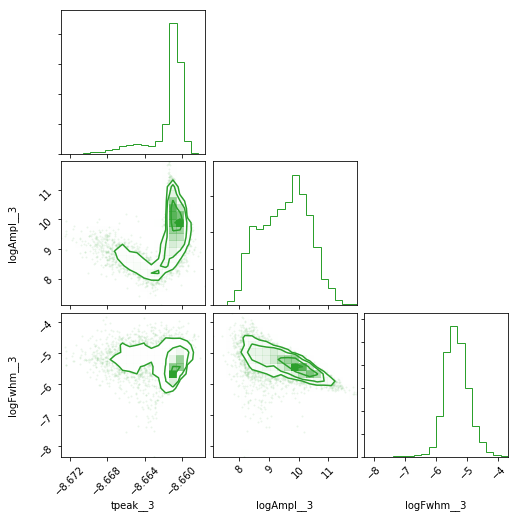

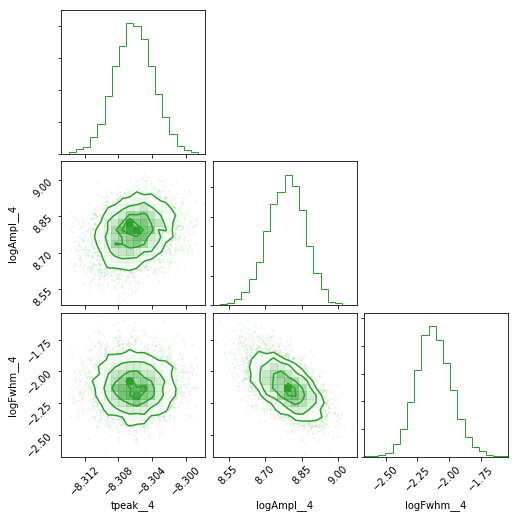

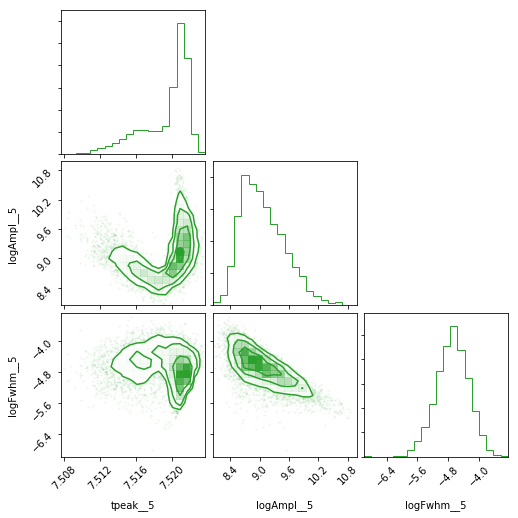

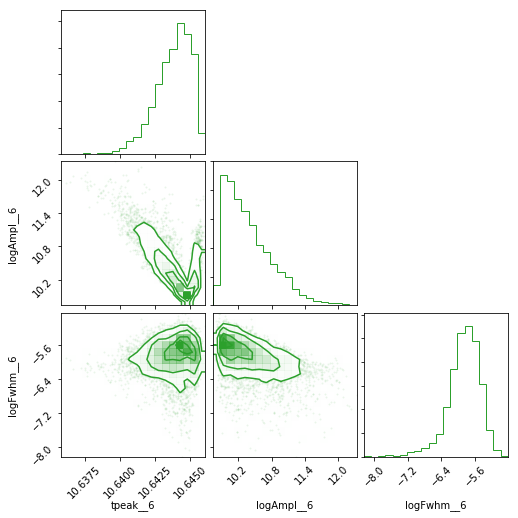

In [19]:
# log corners
samples = pm.trace_to_dataframe(trace, varnames=['tpeak', 'logAmpl', 'logFwhm'])
for i in range(trace['tpeak'].shape[1]):
    corner.corner(samples.loc[:,
                              ['tpeak__{}'.format(i), 'logAmpl__{}'.format(i),
                               'logFwhm__{}'.format(i)]], color='C2');